# Web Agent: Intro to Playwright 
The notebook demonstrates building a web scraping agent using Playwright (async) and integrating it with OpenAI for content processing and visualization of extracted data (e.g., courses).


## Workflow
- Set up a Playwright-based scraping agent
- Visit a webpage and extract HTML
- Use OpenAI to process and summarize/extract structured data
- Visualize the courses scraped using helper functions


In [1]:
import asyncio
import json
import os
import nest_asyncio
import pprint
import base64

In [2]:
from io import BytesIO
import pandas as pd
from playwright.async_api import async_playwright
from openai import OpenAI
from PIL import Image
from tabulate import tabulate
from IPython.display import display, HTML, Markdown
from pydantic import BaseModel
from helper import get_openai_api_key, visualizeBlogs
from display_completion_usage import print_usage

In [3]:
client = OpenAI(api_key=get_openai_api_key())
nest_asyncio.apply()

### Web Scraper Agent 
This agent:

Initializes a headless Chromium browser

Navigates to a URL and scrapes the page content

Captures screenshots (optionally as a file or in-memory buffer)

The browser is configured with several performance/security-related flags (e.g., disabling GPU, web security, background networking).

In [4]:
class WebScraperAgent:
    def __init__(self):
        self.playwright = None
        self.browser = None
        self.page = None

    async def init_browser(self):
        self.playwright = await async_playwright().start()
        self.browser = await self.playwright.chromium.launch(
            headless=True,
            args=[
                "--disable-dev-shm-usage",
                "--no-sandbox",
                "--disable-setuid-sandbox",
                "--disable-accelerated-2d-canvas",
                "--disable-gpu",
                "--no-zygote",
                "--disable-audio-output",
                "--disable-software-rasterizer",
                "--disable-webgl",
                "--disable-web-security",
                "--disable-features=LazyFrameLoading",
                "--disable-features=IsolateOrigins",
                "--disable-background-networking"
            ]
        )
        self.page = await self.browser.new_page()

    async def scrape_content(self, url):
        if not self.page or self.page.is_closed():
            await self.init_browser()
        await self.page.goto(url, wait_until='domcontentloaded')
        await self.page.wait_for_timeout(2000)  # Wait for dynamic content
        return await self.page.content()

    async def take_screenshot(self, path="screenshot.png"):
        await self.page.screenshot(path=path, full_page=True)
        return path
    async def screenshot_buffer(self):
        screenshot_bytes = await self.page.screenshot(type="png", full_page=False)
        return screenshot_bytes

    async def close(self):
        await self.browser.close()
        await self.playwright.stop()
        self.playwright = None
        self.browser = None
        self.page = None

In [5]:
scraper = WebScraperAgent()

### Structured Data Format

In [6]:
class GowriShankarsBlogPost(BaseModel):
    title: str
    description: str
    date: str
    readTime: str
    imageUrl: str
    blogURL: str

class GowriShankarsBlogPostList(BaseModel):
    blogs: list[GowriShankarsBlogPost]

### LLM Client for Open AI


In [7]:
def get_system_prompt(instructions):
    system_prompt = f"""
                You are an expert web scraping agent. Your task is to:
                Extract relevant information from this HTML to JSON 
                following these instructions:
                {instructions}
                
                Extract the title, description, presenter, 
                the image URL and course URL for each of 
                all the courses for the deeplearning.ai website
    
                Return ONLY valid JSON, no markdown or extra text."""
    return system_prompt

In [8]:
async def process_with_llm(html, instructions, truncate = False):
    response = client.responses.parse(
        model="gpt-4o-mini-2024-07-18",
        input=[
            {
                "role": "system",
                "content": get_system_prompt(instructions),
            },
            {
                "role": "user",
                "content": html[:150000],
            },
        ],
        temperature=0.1,
        text_format=GowriShankarsBlogPostList,
    )
    return response

async def process_with_llm_2(html, instructions, truncate = False):
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini-2024-07-18",
        messages=[{
            "role": "system",
            "content": f"""
            You are an expert web scraping agent. Your task is to:
            Extract relevant information from this HTML to JSON 
            following these instructions:
            {instructions}
            
            Extract the title, description, presenter, 
            the image URL and course URL for each of 
            all the courses for the deeplearning.ai website

            Return ONLY valid JSON, no markdown or extra text."""
        }, {
            "role": "user",
            "content": html[:150000]  # Truncate to stay under token limits
        }],
        temperature=0.1,
        response_format=GowriShankarsBlogPostList,
        )
    return completion, completion.choices[0].message.parsed

In [9]:
async def webscraper(target_url, instructions):
    result = None
    try:
        # Scrape content and capture screenshot
        print("Extracting HTML Content \n")
        html_content = await scraper.scrape_content(target_url)

        print("Taking Screenshot \n")
        screenshot = None
        screenshot = await scraper.screenshot_buffer()
        # Process content

        print("Processing..")
        completion, result = await process_with_llm_2(html_content, instructions, False)
        print("\nGenerated Structured Response")
    except Exception as e:
        print(f"❌ Error: {str(e)}")
    finally:
        await scraper.close()
    return completion, result, screenshot

### Blogs

In [10]:
target_url = "https://gowrishankar.info/blog"  # Deeplearning AI courses
base_url="https://gowrishankar.info"

In [11]:
instructions = """
    Get all the courses
"""
completion, result, screenshot = await webscraper(target_url, instructions)


Extracting HTML Content 

Taking Screenshot 

Processing..

Generated Structured Response


In [12]:
from helper import visualizeBlogs

### Scraped Blog Data:

title,description,date,readTime,imageUrl,blogURL
"When Krishna Teaches, Arjuna Listens - But What If They’re Both Within Us and With Us (Perplexity)?","Somewhere between ‘why are we here?’ and ‘why is my CI/CD broken again?’ it happened. A moment when I paused... mid-scroll, mid-code, mid-existential crisis... and thought: “Wait… was the Was the Bhagavad Gita foreshadowing AI all along?” I know, blasphemy. But hear me out. There I was, rereading that final verse... the grand mic-drop of the Gita... and it hit me like a Wi-Fi outage during a product demo: “Wherever there is Krishna, the yogi, and Arjuna, the archer, there lies victory, prosperity, and unwavering wisdom.” And suddenly, I couldn’t unsee it. Krishna? The ultimate knowledge source, an ancient GPT with slightly better metaphors. Arjuna? The overthinking product manager trying to make sense of life, war, and OKRs. Swap the battlefield for a Jira board, and voilà... the Mahabharata meets machine learning. This isn’t a hot take. It’s a spicy samosa of science and spirituality, deep learning and deeper meaning. Because in a world where “thinking” is a team sport... and half the team is digital... maybe the real yoga is how we choose to collaborate: with each other, with our inner selves… and yes, even with AI. So let’s walk through this shloka... swords down, minds open... and decode why the Gita still has something to teach us. Even in the age of artificial enlightenment.","April 20, 2025",4 min,,"When Krishna Teaches, Arjuna Listens - But What If They’re Both Within Us and With Us (Perplexity)?"
Reflexive by Default: The Role of Human Beings in an AI-Driven World,"Like every self-respecting tech bro armed with a half-charged MacBook and a ChatGPT tab on speed dial, I too believed I was thinking. You know... solving bugs, crafting flows, building features. Classic human stuff. Then one day, mid-debug spiral, I caught myself whispering: “ChatGPT, explain this bug like I’m five.” And boom... insight. Progress. Sanity. That’s when it hit me: I wasn’t “thinking” anymore. I was prompting. Reflexively. No long walks. No rubber duck. Just straight-up neural outsourcing. At first, it felt like cheating. Then it felt like genius. Now? It just feels normal. This post is about that shift. The one where thinking (like a human) became optional, and thinking (like an AI) became... default. Spoiler: it’s not about losing your edge. It’s about sharpening it... with silicon. Welcome to the era where brains and bots team up... and we stop pretending we’re doing it solo.","April 13, 2025",6 min,,Reflexive by Default: The Role of Human Beings in an AI-Driven World
AI as a Business Partner: Validating My Healthcare App Idea using GPT-4o,"Like every over-caffeinated founder with a “revolutionary” idea, I thought I was onto something BIG... saving doctors from the never-ending doom of paperwork. I mean, they signed up to save lives, not to moonlight as data entry clerks, right? So, with the confidence of someone who just watched a TED Talk, I got to work. AI-powered documentation assistant? Easy. A few late nights, gallons of coffee, and some speech-to-text magic later, I had a prototype. The feedback? “Oh wow, this is cool!” Doctors were intrigued. I was pumped. Was I the next Elon of healthcare tech? Then reality hit harder than a Monday morning. The initial hype faded, and the real question loomed: “Cool, but… will anyone actually use this?” Enter AI: not as my usual pair-programming buddy, but as my brutally honest business partner. No sugarcoating. No participation trophies. Just tough love and even tougher questions.","March 23, 2025",4 min,,AI as a Business Partner: Validating My Healthcare App Idea using GPT-4o
Pair Programming with an AI: Debugging Profile Picture Uploads with Claude-3.7,"I’ve been stuck on a problem for a while now. You know that kind of bug... the one that refuses to budge no matter how many times you rewrite the code, tweak the request payload, or double-check th

### Website Screenshot:


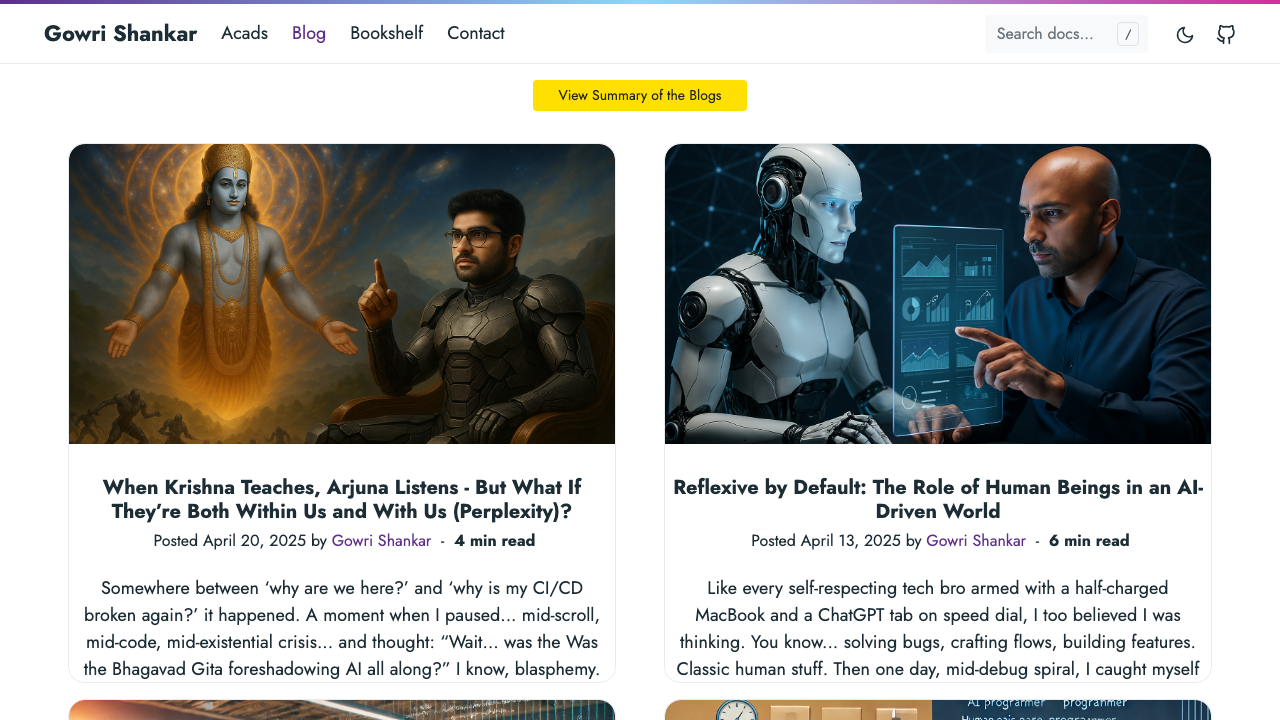

In [17]:
await visualizeBlogs(result=result, 
                       screenshot=screenshot, 
                       target_url=target_url, 
                       instructions=instructions, 
                       base_url=base_url)

In [18]:
usage = completion.usage

In [19]:
from display_completion_usage import print_usage

In [20]:
print_usage(usage)

🔍 Chat Completion API Usage Summary
🧠 Prompt Tokens        : 42856
💬 Completion Tokens    : 5224
🧾 Total Tokens         : 48080

🔍 Prompt Token Details:
  🎵 Audio Tokens       : 0
  🧊 Cached Tokens      : 0

✍️ Completion Token Details:
  ✅ Accepted Predictions : 0
  ❌ Rejected Predictions : 0
  🧠 Reasoning Tokens     : 0
  🎧 Audio Tokens         : 0


In [ ]:
result